In [13]:
%cd ..
%load_ext autoreload
%autoreload

from torchvision.transforms import CenterCrop, Compose, Resize, ToTensor
from main_ibot import DataAugmentationiBOT, ImageFolderMask, get_args_parser
import os 
print(os.environ['MICROUS_DATA'])

args = get_args_parser().parse_args([])
args.data_path = os.environ['MICROUS_DATA']
args.local_crops_number = 0

transform = DataAugmentationiBOT(
    [0.2, 0.8],
    [0.1, 0.2],
    args.global_crops_number,
    args.local_crops_number,
    512,
    args.local_crops_size, 
    initial_crop_size=512,
    mean=[0, 0, 0],
    std=[1,1,1],
    blur_prob_1=0, blur_prob_2=0, 
    jitter_prob=0, solarization_prob=0, 
    initial_resize_size=1024
)
pred_size = args.patch_size * 8 if "swin" in args.arch else args.patch_size

# transform = Compose([
#     ToTensor(),
#     Resize(1024), 
#     CenterCrop(1024)
# ])

dataset = ImageFolderMask(
    args.data_path,
    transform=transform,
    patch_size=pred_size,
    pred_ratio=args.pred_ratio,
    pred_ratio_var=args.pred_ratio_var,
    pred_aspect_ratio=(0.3, 1 / 0.3),
    pred_shape=args.pred_shape,
    pred_start_epoch=args.pred_start_epoch,
)

/fs01/home
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/ssd005/projects/exactvu_pca/unlabelled_microus_png


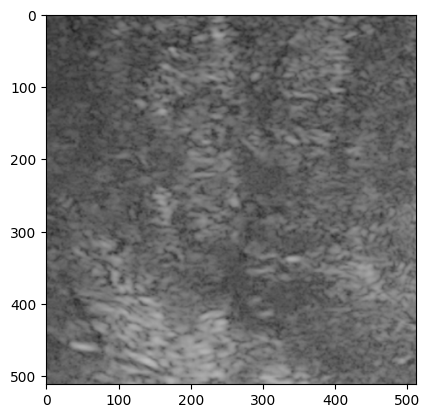

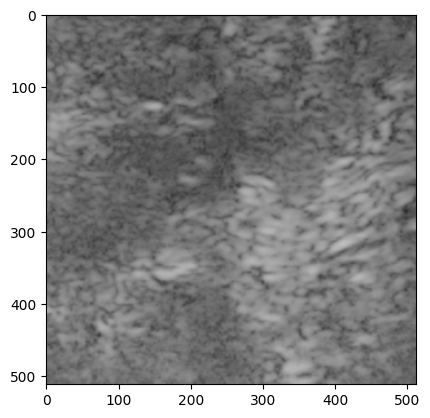

In [14]:
from matplotlib import pyplot

image, *_ = dataset[0]

for image in image: 
    pyplot.figure()
    pyplot.imshow(image.permute(1, 2, 0))

In [4]:
from torch import nn

import torch 


class FFTPatchEmbed(nn.Module): 
    def __init__(self, img_size=224, patch_size=16, in_chans=3, embed_dim=768): 
        super().__init__()
        num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.img_size = img_size 
        self.patch_size = patch_size 
        self.fourier_patch_size = (patch_size // 2) + 1
        self.num_patches = num_patches 

        self.proj = nn.Linear(in_chans * self.fourier_patch_size * self.patch_size, embed_dim)
        nn.init.normal_(self.proj.weight, 0, 0.0001)

    def get_patch_level_fft(self, x):
        B, C, H, W = x.shape 
        P = self.patch_size
        PF = self.fourier_patch_size
        nP = H//P
        patches = x.resize(B, C, nP, P, nP, P)
        patches = patches.permute(0, 1, 2, 4, 3, 5)
        patches = torch.fft.rfft2(patches, norm='forward').abs().log()

        # sometimes patches has inf values, fill them 
        patches[torch.isinf(patches)] = patches.max()

        return patches

    def forward(self, x): 
        B, C, H, W = x.shape 
        P = self.patch_size
        PF = self.fourier_patch_size
        nP = H//P
        patches = self.get_patch_level_fft(x)
        patches_flat = patches.permute(0, 2, 3, 1, 4, 5).resize(B, nP, nP, C*P*PF)
        proj = self.proj(patches_flat).abs()
        return proj.permute(0, 3, 1, 2)

In [5]:
dataset[0][0][0].shape

torch.Size([3, 1024, 1024])

/h/pwilson/anaconda3/envs/ai/lib/python3.11/site-packages/torch/_tensor.py:836: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


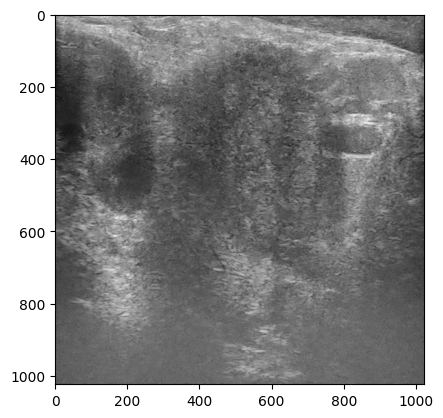

In [6]:
im = dataset[0][0][0].unsqueeze(0)
pyplot.imshow(im[0].permute(1, 2, 0))
fmap = FFTPatchEmbed(img_size=1024, patch_size=64, in_chans=3, embed_dim=768)
out = fmap(im)

torch.Size([1, 3, 16, 16, 64, 33])


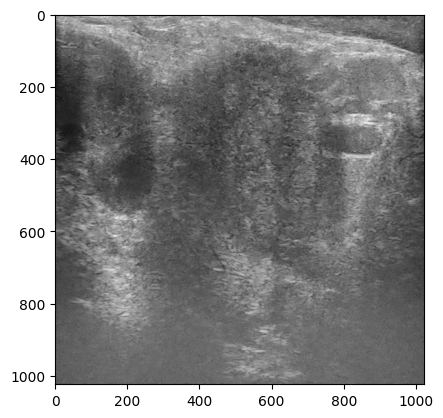

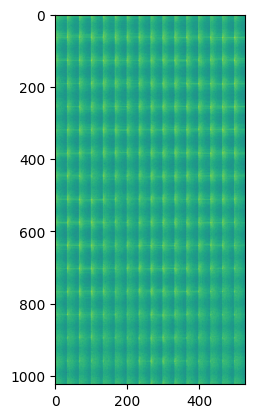

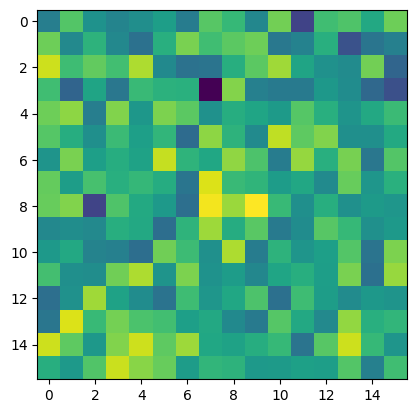

In [7]:
im = dataset[0][0][0].unsqueeze(0)
pyplot.imshow(im[0].permute(1, 2, 0))
fmap = FFTPatchEmbed(img_size=1024, patch_size=64, in_chans=3, embed_dim=768)
pyplot.figure()

out = fmap.get_patch_level_fft(im)
print(out.shape)
B, C, npH, npW, pH, pW = out.shape
out = out.permute(0, 1, 2, 4, 3, 5).resize(B, C, npH * pH, npW * pW)
pyplot.imshow(out[0][0])
pyplot.figure()


out = fmap(im)
pyplot.imshow(out[0, 0].detach())

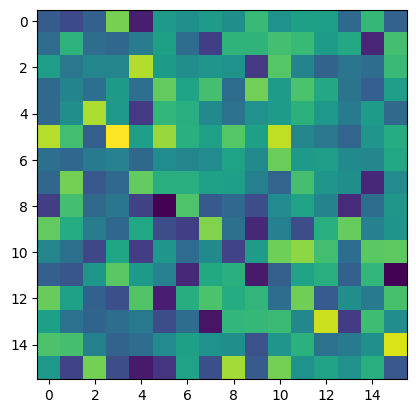

In [196]:
pyplot.imshow(out[0, 0].detach())

In [120]:
print(out.min(), out.max())

tensor(5.6147e-07, grad_fn=<MinBackward1>) tensor(0.2765, grad_fn=<MaxBackward1>)


In [86]:
sum([p.numel() for p in fmap.parameters()])

4866816

In [57]:
fmap.shape

torch.Size([1, 16, 16, 768])

In [ ]:
from dataclasses import dataclass, fields 

@dataclass 
class A: 
    b: int 

In [6]:
import argparse

class CustomAction(argparse.Action):
    def __call__(self, parser: argparse.ArgumentParser, namespace, values, option_string=None):
        import json 
        d = json.load(open(values))
        parser.set_defaults(d)
        setattr(namespace, self.dest, values)

parser = argparse.ArgumentParser()
parser.add_argument('-c', action=CustomAction)
parser.parse_args(['-c', '1'])

FileNotFoundError: [Errno 2] No such file or directory: '1'